In [28]:
#Importando librerías necesarias
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
import cv2
import scipy.misc
from matplotlib import cm
from timeit import default_timer as timer
from mpl_toolkits.mplot3d import Axes3D 
from scipy import ndimage

In [2]:
#la direccion actual se encuentra en ~/CodigosAlejandro/
#Importando datos

datos  = np.loadtxt('data.dat', delimiter= ' ')
random = np.loadtxt('rand0.dat',delimiter= ' ')
print('número de datos: ', len(datos))
print('número de datos random: ', len(random))

número de datos:  32768
número de datos random:  32768


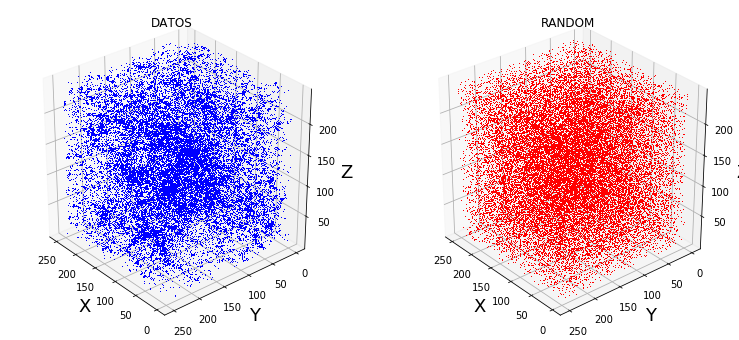

In [3]:
#Visualizando datos
fig = plt.figure(figsize=(13,6))
#subplot(columns, rows, position, projection)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(datos[:,0],datos[:,1],datos[:,2],',b')
ax.set_xlabel('X',fontsize=18)
ax.set_ylabel('Y',fontsize=18)
ax.set_zlabel('Z',fontsize=18)
plt.title('DATOS')
ax.view_init(30, 140)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot3D(random[:,0],random[:,1],random[:,2],',r')
ax.set_xlabel('X',fontsize=18)
ax.set_ylabel('Y',fontsize=18)
ax.set_zlabel('Z',fontsize=18)
plt.title('RANDOM')
ax.view_init(30, 140)


plt.show()

In [4]:
#eliminando la 4 columna de ambos arrays de datos (estos objets ya son arrays de numpy desde el momento de importarlos con loadtxt)
data = datos.T[0:3].T
rand = random.T[0:3].T

In [19]:
#función para la construcción de la imagen 2d
def imag(x,y,t,cmap):
    plt.figure(figsize=(6,6), dpi=100)
    plt.imshow(x,origin='lower',cmap=cmap)
    cax=plt.colorbar()
    plt.contour(x,10,cmap=plt.cm.gray,linewidths=0.5)
    plt.ylabel('$r_{\pi}$',fontsize = 16)
    plt.xlabel('$r_{p}$',fontsize = 16)
    plt.title(y,fontsize = 16)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax.set_label(t,labelpad = 15,fontsize = 15)
    line_colour1 = ('royalblue', 'blue', 'mediumblue', 'darkblue')
    plt.plot()

In [5]:
#Función de correlación Landy-Szalay
def estimador_LS(DD, RR, DR):
    return (DD - 2*DR + RR)/RR

In [6]:
#Función de correlación de Hamiltonn
def estimador_HAM(DD, RR, DR):
    return ((DD*RR)/(DR**2) - 1)

In [7]:
def vector_unitario(vector):
    return (vector.T/np.sqrt(vector[:,0]**2 + vector[:,1]**2 + vector[:,2]**2)).T


In [8]:
def vector_paralelo(vector_unit_rab, vector_rab):
    matrix = np.multiply(vector_unit_rab, vector_rab)
    return (matrix[:,0] + matrix[:,1] + matrix[:,2])

In [9]:
#Función principal
def calcular_histogramas2D(puntosD, puntosR, puntoOBS, nbins, xmin, xmax, ymin, ymax):
    #nbins es el numero de particiones en el intervalo [lim_inf, lim_sup]
    #Variables de control para los histogramas
    DD = np.zeros((nbins,nbins))
    DR = np.zeros((nbins,nbins))
    RR = np.zeros((nbins,nbins))
    n = 0 #variable auxiliar

    for (i,j) in zip(puntosD, puntosR):
        n+=1
        #Para DD
        pm_DD = (i + puntosD[n:])/2 # puntos medios entre punto pivote y el resto de datos en D (LISTA DE LISTAS -- ES UNA MATRIZ)
        r_ab = i - puntosD[n:] #la diferencia entre los puntos pivote y el resto de datos en D (MATRIZ)
        r_ab_DD = np.sqrt(r_ab[:,0]**2 + r_ab[:,1]**2 + r_ab[:,2]**2) # distancia rab entre los puntos anteriores (LISTA)
        r_unit_DD = vector_unitario(pm_DD - puntoOBS) #vector r unitario para facilitar calculos
        r_paralelo_DD = vector_paralelo(r_unit_DD,r_ab)

        #r_paralelo_DD = np.multiply(r_ab, r_unit_DD) # la componente paralela es el valor absoluto del producto punto rab*runit
        r_perpendicular_DD = np.sqrt(r_ab_DD**2 - r_paralelo_DD**2) # es trivial deducir esta relacion

        HDDdis_lst, xbins_lst, ybins_lst = np.histogram2d(r_paralelo_DD,r_perpendicular_DD, bins=nbins, range=([[xmin,xmax],[ymin, ymax]]))
        #La función histogram2d regresa una lista con los valores ordenados de la cantidad de distancias que se repiten en cada intervalo (bin) por cada eje y 
        # otras dos listas con los intervalos utilizados (bin_lst) en los dos ejes
        DD += 2*HDDdis_lst

        #Para RR, como se corre el for  en paralelo, no es necsario un nuevo contador, por eso empleamos n
        pm_RR = (j + puntosR[n:])/2 
        R_ab = j - puntosR[n:]
        r_ab_RR = np.sqrt(R_ab[:,0]**2 + R_ab[:,1]**2 + R_ab[:,2]**2)
        r_unit_RR = vector_unitario(puntoOBS - pm_RR)
        r_paralelo_RR = vector_paralelo(r_unit_RR, R_ab)
        # r_paralelo_RR = np.absolute(np.dot(R_ab, r_unit_RR))
        r_perpendicular_RR = np.sqrt(r_ab_RR**2 - r_paralelo_RR**2)
        
        HRRdis_lst, xbins_lst, ybins_lst = np.histogram2d(r_paralelo_RR, r_perpendicular_RR, bins=nbins, range=([[xmin,xmax],[ymin, ymax]]))
        RR += 2*HRRdis_lst

    for k in puntosD:
        pm_DR = (k + puntosR)/2
        r_ab = k - puntosR
        r_ab_DR = np.sqrt(r_ab[:,0]**2 + r_ab[:,1]**2 + r_ab[:,2]**2)
        r_unit_DR = vector_unitario(puntoOBS-pm_DR)
        r_paralelo_DR = vector_paralelo(r_unit_DR,r_ab)
        #r_paralelo_DR = np.absolute(np.dot(r_ab, r_unit_DR))
        r_perpendicular_DR = np.sqrt(r_ab_DR**2  - r_paralelo_DR**2)
        
        HDRdis_lst, xbins_lst, ybins_lst = np.histogram2d(r_paralelo_DR, r_perpendicular_DR, bins=nbins, range=([[xmin, xmax],[ymin, ymax]]))
        DR += HDRdis_lst
    
    return DD, DR, RR, xbins_lst, ybins_lst


In [10]:
#Código principal
to = timer()
#punto de observación
pobs = np.array([125, 125, 100000])
DD, DR, RR, x, y = calcular_histogramas2D(data, rand, pobs, 30, 0, 180, 0, 180)
tf = timer()

print(f'Finalizado en: {round(tf-to,2)} segundos')

Finalizado en: 289.82 segundos


In [11]:
#calculando los estimadores
eps_LS_2d = estimador_LS(DD,RR,DR)
eps_HAM_2d = estimador_HAM(DD, RR, DR)

In [13]:
#Para que es este pedazo de codigo?
top = np.max(eps_LS_2d[np.where(eps_LS_2d < 0.3)])
#down = np.min(eps_LS_2d_2[np.where(eps_LS_2d_2 > -0.1)])
eps_LS_2d[np.where(eps_LS_2d > 0.3)] = top
#eps_LS_2d_2[np.where(eps_LS_2d_2 < -0.1)] = down

In [33]:
p = 1
sig = 1

blur_OH = cv2.blur(eps_LS_2d,(1,1))

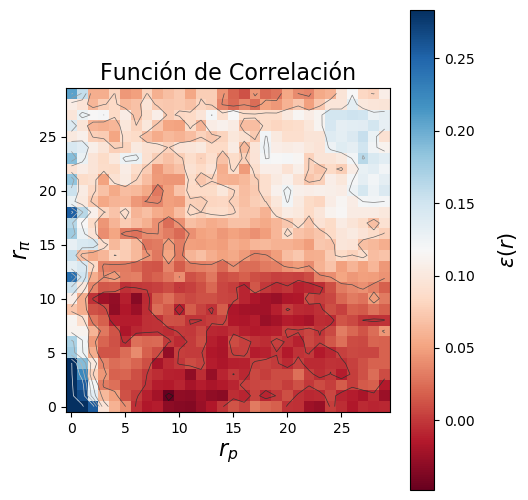

In [34]:
imag(blur_OH,'Función de Correlación','$\epsilon(r)$',cmap='RdBu')

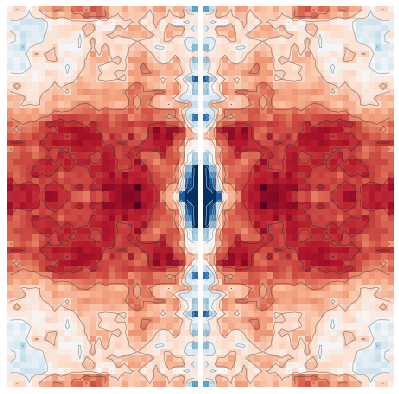

In [18]:
#visualizando imagen anterior rotada y 4 veces
plt.figure(figsize = (7,7))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 

ax1 = plt.subplot(gs1[0])
rotated_img = ndimage.rotate(np.rot90(blur_OH), 90)
plt.imshow(rotated_img, cmap='RdBu')
plt.contour(rotated_img,10,cmap=plt.cm.gray,linewidths=0.5)
plt.axis('off')
ax1 = plt.subplot(gs1[1])
rotated_img = ndimage.rotate(blur_OH.T,90)
plt.imshow(rotated_img, cmap='RdBu')
plt.contour(rotated_img,10,cmap=plt.cm.gray,linewidths=0.5)
plt.axis('off')
ax1 = plt.subplot(gs1[2])
rotated_img = ndimage.rotate(blur_OH.T,-90)
plt.imshow(rotated_img, cmap='RdBu')
plt.contour(rotated_img,10,cmap=plt.cm.gray,linewidths=0.5)
plt.axis('off')
ax1 = plt.subplot(gs1[3])
rotated_img = ndimage.rotate(blur_OH, 0)
plt.imshow(rotated_img, cmap='RdBu')
plt.contour(rotated_img,10,cmap=plt.cm.gray,linewidths=0.5)
plt.axis('off')
plt.show()